In [ ]:
学习torch的一些用法
randn(*size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor
tensor(data, dtype=None, device=None, requires_grad=False, pin_memory=False) -> Tensor

Tensor instance.index_select(dim, index) -> Tensor
torch.index_select(input, dim, index, out=None) -> Tensor
torch.zeros(*size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor
torch.mm(input, mat2, out=None) -> Tensor
Tensor instance.view(*shape) -> Tensor
torch.utils.data.TensorDataset()
torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, 
                            batch_sampler=None, num_workers=0, collate_fn=None, 
                            pin_memory=False, drop_last=False, timeout=0, 
                            worker_init_fn=None, multiprocessing_context=None)
torch.nn.Linear(in_features, out_features, bias=True)
torch.nn.Sequential(*args)
torch.nn.Sequential.add_module(name, module)
torch.optim()
  -adadelta\adagrad\adam\adamax\adamw\asgd\lbfgs\lr_scheduler\optimizer\rmsprop\rprop\sgd\sparse_adam


In [14]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.3.0


In [ ]:
#使用

In [18]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_inputs, dtype=torch.float32)
labels = true_w[0]*features[:,0] + true_w[1]*features[:,1] + true_b
# labels = true_w[0]*features[:,0] + true_w[1]*features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

labels[:4]

tensor([3.6695, 5.2555, 2.8657, 4.0290])

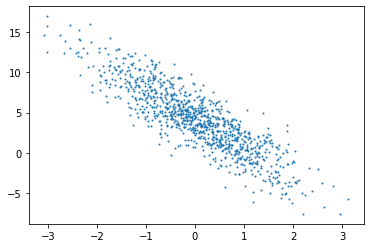

In [22]:
plt.scatter(features[:,1], labels,1)

In [24]:
#读取数据集
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # random read 10 samples
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # the last time may be not enough for a whole batch
        yield  features.index_select(0, j), labels.index_select(0, j)


In [25]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.8177, -0.6162],
        [ 0.2482, -0.7922],
        [-1.0311,  0.2423],
        [-0.0076, -0.9662],
        [-0.1112,  0.2900],
        [-0.2954, -0.0902],
        [-0.1489, -2.3750],
        [-0.8977, -0.8364],
        [ 1.0772,  1.2821],
        [ 1.7575,  0.5416]]) 
 tensor([ 4.6623,  7.3623,  1.3100,  7.4710,  2.9871,  3.9010, 11.9688,  5.2551,
         2.0019,  5.8624])


In [40]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

#requires_grad=True告诉PyTorch这些张量需要支持求导。
#这样PyTorch将记录在张量上完成的所有操作，以便它可以在反向传播过程中自动计算梯度！
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [32]:
#定义模型
def linreg(X, w, b):
    #torch.mm(a, b)是矩阵a和b矩阵相乘，比如a的维度是(1, 2)，b的维度是(2, 3)，返回的就是(1, 3)的矩阵
    return torch.mm(X, w) + b 

In [33]:
#定义损失函数
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [34]:
#定义随机梯度下降
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # ues .data to operate param without gradient track


In [41]:
#训练
# super parameters init
lr = 0.01
num_epochs = 5

net = linreg
loss = squared_loss

# training
for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        l.backward()  
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        w.grad.data.zero_() #清零导数，以便开始下一轮循环，否则导数会在原来的基础上累加，而非替代原来的数
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))


epoch 1, loss 2.221731
epoch 2, loss 0.299754
epoch 3, loss 0.040558
epoch 4, loss 0.005513
epoch 5, loss 0.000789


In [42]:
w, true_w, b, true_b

(tensor([[ 1.9882],
         [-3.3790]], requires_grad=True),
 [2, -3.4],
 tensor([4.1699], requires_grad=True),
 4.2)

In [ ]:
#使用pytorch实现

In [63]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1) #设置随机种子，使结果可以复现

torch.set_default_tensor_type('torch.FloatTensor')

In [69]:
features.size()

torch.Size([1000, 2])

In [76]:
import torch.utils.data as Data

batch_size=10
# combine featues and labels of dataset
dataset = Data.TensorDataset(features, labels)

# put dataset into DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,            # torch TensorDataset format
    batch_size=batch_size,      # mini batch size
    shuffle=True,               # whether shuffle the data or not
    num_workers=1,              # read data in multithreading 本机只能设为0或1，其它会报错
)


In [78]:
#定义模型
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()      # call father function to init 
        self.linear = nn.Linear(n_feature, 1)  # function prototype: `torch.nn.Linear(in_features, out_features, bias=True)`

    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [80]:
# ways to init a multilayer network
# method one
# net = nn.Sequential(
#     nn.Linear(num_inputs, 1)
#     # other layers can be added here
#     )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ......

# method three
# from collections import OrderedDict
# net = nn.Sequential(OrderedDict([
#           ('linear', nn.Linear(num_inputs, 1))
#           # ......
#         ]))

print(net)
print(net[0])


Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [82]:
#初始化模型参数
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)  
# or you can use `net[0].bias.data.fill_(0)` to modify it directly


Parameter containing:
tensor([0.], requires_grad=True)

In [83]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.0174, 0.0021]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [87]:
#定义损失函数
loss = nn.MSELoss()
# nn built-in squared loss function
# function prototype: `torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')`


In [88]:
#定义优化函数
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)   # built-in random gradient descent function
print(optimizer)  # function prototype: `torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [89]:
#训练
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad() # reset gradient, equal to net.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000063
epoch 2, loss: 0.000143
epoch 3, loss: 0.000093


In [90]:
# result comparision
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 1.9995, -3.4007]])
4.2 tensor([4.1999])
